## __GPM자료를 이용해서 머신러닝 적용해보기__
2022.04.01 @Yeji Choi

- glob: 파일리스트관련 작업을 위한 라이브러리
- 사용할 데이터는 dacon __"위성관측 데이터 활용 강수량 산출 AI 경진대회"__ 데이터 활용

In [1]:
import numpy as np
import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path='/content/drive/MyDrive/Colab Notebooks/dacon/'
file_list=sorted(glob.glob(path+'*.npy'))

In [4]:
file_list[0], len(file_list)

('/content/drive/MyDrive/Colab Notebooks/dacon/dacon_subset_010487_009.npy',
 41)

In [5]:
data=np.load(file_list[1])
print(data.shape)
data[0,:]

(1600, 20)


array([ 1.68862244e+02,  9.34734116e+01,  1.85288925e+02,  1.13200882e+02,
        2.02379120e+02,  2.08153702e+02,  1.46214447e+02,  2.47558762e+02,
        2.03534882e+02,  2.69611023e+02,  2.64823975e+02,  2.60497650e+02,
        2.66039948e+02,  0.00000000e+00,  1.24702662e-01,  0.00000000e+00,
       -5.82397232e+01,  4.02777176e+01, -5.82418747e+01,  4.02751045e+01])

In [6]:
import matplotlib.pyplot as plt

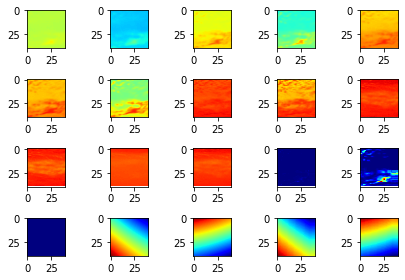

In [7]:
width=15
height=15
rows = 4
cols = 5
axes=[]
fig=plt.figure()

data2d=data.reshape(40,40,20)

for a in range(rows*cols):
    axes.append(fig.add_subplot(rows, cols, a+1) )
    if a < 13:
        plt.imshow(data2d[:,:,a],cmap='jet',vmin=0, vmax=300)
    elif a==13:
        plt.imshow(data2d[:,:,a],cmap='jet',vmin=0, vmax=200)
    else:
        plt.imshow(data2d[:,:,a],cmap='jet')
fig.tight_layout()    
plt.show()

### 1. 학습자료 준비
- 입력은 9개 채널의 마이크로파 밝기 온도
- 출력은 강수 유무

In [8]:
x_data=[]
y_class=[]
y_reg=[]
for fi in file_list[:41]:
    data=np.load(fi)
    x_data.append(data[:,:10])
    y=np.where(data[:,14]==0,0,1)
    y_class.append(y)
    y_reg.append(data[:,14])

In [9]:
x_data=np.array(x_data)
y_class=np.array(y_class)
y_reg=np.array(y_reg)
x_data.shape, y_class.shape, y_reg.shape

((41, 1600, 10), (41, 1600), (41, 1600))

In [10]:
x_data=x_data.reshape(-1,10)
y_class=y_class.flatten()
y_reg=y_reg.flatten()
x_data.shape, y_class.shape, y_reg.shape

((65600, 10), (65600,), (65600,))

In [11]:
a,b=np.unique(y_class,return_counts=True)
a,b

(array([0, 1]), array([21222, 44378]))

In [12]:
b=b/(b[0]+b[1])
b

array([0.3235061, 0.6764939])

In [13]:
import matplotlib.pyplot as plt

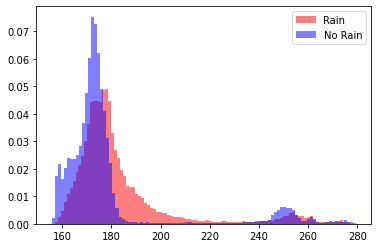

In [14]:
x_data=np.clip(x_data,0,300)
p_norain=y_class==0
p_rain=y_class==1
plt.hist(x_data[p_rain,0],bins=100, density=True, alpha=0.5, color='r', label='Rain')
plt.hist(x_data[p_norain,0],bins=100, density=True, alpha=0.5, color='b', label='No Rain')
plt.legend()
plt.show()

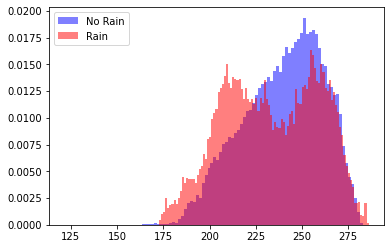

In [15]:
plt.hist(x_data[p_rain,8],bins=100, density=True, alpha=0.5, color='b', label='No Rain')
plt.hist(x_data[p_norain,8],bins=100, density=True, alpha=0.5, color='r', label='Rain')
plt.legend()
plt.show()

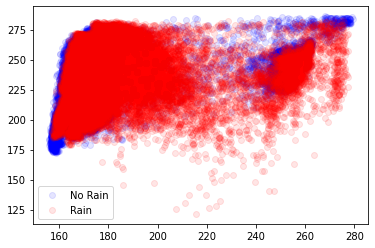

In [16]:
plt.scatter(x_data[p_norain,0], x_data[p_norain,8], c="b", alpha=0.1, label='No Rain')
plt.scatter(x_data[p_rain,0], x_data[p_rain,8], c="r", alpha=0.1, label='Rain')
plt.legend()
plt.show()

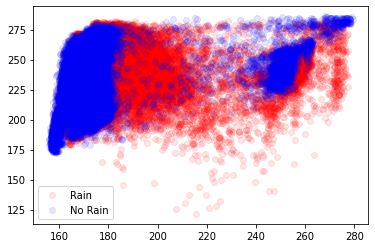

In [17]:
plt.scatter(x_data[p_rain,0], x_data[p_rain,8], c="r", alpha=0.1, label='Rain')
plt.scatter(x_data[p_norain,0], x_data[p_norain,8], c="b", alpha=0.1, label='No Rain')
plt.legend()
plt.show()

### 2.머신러닝 알고리즘을 활용하여 적용하기

- 사이킷런 설치하기- 파이썬 머신러닝 알고리즘  
`
conda install -c intel scikit-learn
`

#### __학습자료 나누기__ (Train/Test split)

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
x_train, x_test, y_train, y_test= train_test_split(x_data, y_class, test_size=0.3, random_state=53, stratify=y_class)

In [20]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((45920, 10), (45920,), (19680, 10), (19680,))

In [21]:
a,b=np.unique(y_train, return_counts=True)
c,d=np.unique(y_test, return_counts=True)
b/(b[0]+b[1]), d/(d[0]+d[1])

(array([0.32349739, 0.67650261]), array([0.32352642, 0.67647358]))

### - kNN 분류기

In [22]:
from sklearn.neighbors import KNeighborsClassifier

In [23]:
model = KNeighborsClassifier(n_neighbors=1)

In [24]:
model.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [25]:
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

In [26]:
np.mean(y_train == y_train_pred)

1.0

In [27]:
np.mean(y_test == y_test_pred)

0.8555386178861789

In [28]:
train_results = {}
for n_num in range(1, 11):
    model = KNeighborsClassifier(n_neighbors=n_num)
    model.fit(x_train, y_train)
    train_score = model.score(x_train, y_train)
    test_score = model.score(x_test, y_test)
    train_results[n_num] = {
        'train': train_score, 'test': test_score}

In [29]:
train_results

{1: {'test': 0.8555386178861789, 'train': 1.0},
 2: {'test': 0.8411077235772357, 'train': 0.9232578397212543},
 3: {'test': 0.8651422764227642, 'train': 0.9292247386759582},
 4: {'test': 0.8590447154471544, 'train': 0.9085148083623693},
 5: {'test': 0.8701219512195122, 'train': 0.9107360627177701},
 6: {'test': 0.8629573170731707, 'train': 0.9005226480836237},
 7: {'test': 0.8674796747967479, 'train': 0.9012848432055749},
 8: {'test': 0.864329268292683, 'train': 0.8941202090592334},
 9: {'test': 0.8667682926829269, 'train': 0.8957534843205575},
 10: {'test': 0.8653455284552846, 'train': 0.8907229965156794}}

In [30]:
import pandas as pd
evaluation = pd.DataFrame(train_results).T

In [31]:
evaluation

,train,test
1,1.000000,0.855539
2,0.923258,0.841108
3,0.929225,0.865142
4,0.908515,0.859045
5,0.910736,0.870122
6,0.900523,0.862957
7,0.901285,0.867480
8,0.894120,0.864329
9,0.895753,0.866768
10,0.890723,0.865346


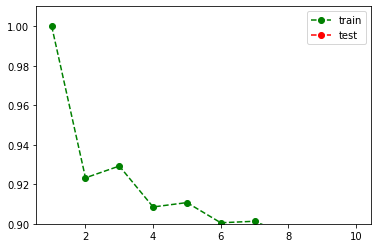

In [32]:
style = {'train': 'go--', 'test': 'ro--'}
evaluation.plot(style=style, ylim=(0.8, 1.01))
plt.show()

### - kNN Regressor

In [33]:
from sklearn.neighbors import KNeighborsRegressor

In [34]:
x_train, x_test, y_train, y_test= train_test_split(x_data, y_reg, test_size=0.3, random_state=53)

In [35]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((45920, 10), (45920,), (19680, 10), (19680,))

In [36]:
model = KNeighborsRegressor().fit(x_train, y_train)

In [37]:
y_test_pred = model.predict(x_test)

- 예측 평가 지표

In [38]:
from sklearn.metrics import r2_score

In [39]:
r2_score(y_test, y_test_pred)

0.6792251087042893

In [40]:
model.score(x_train, y_train)

0.7703583450651275

In [41]:
model.score(x_test, y_test)

0.6792251087042893

In [42]:
train_results = {}
for n_num in range(1, 11):
    model = KNeighborsRegressor(n_neighbors=n_num)
    model.fit(x_train, y_train)
    train_score = model.score(x_train, y_train)
    test_score = model.score(x_test, y_test)
    train_results[n_num] = {
        'train': train_score, 'test': test_score}

In [43]:
evaluation = pd.DataFrame(train_results).T

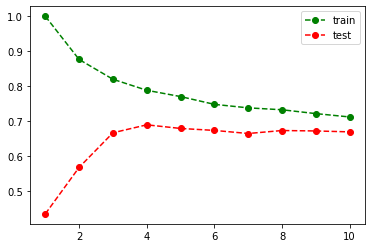

In [44]:
evaluation.plot(style=style)
plt.show()

### - 선형회귀 Linear Regression

In [45]:
from sklearn.linear_model import LinearRegression

In [46]:
model = LinearRegression().fit(x_train, y_train)

In [47]:
x_train.shape, model.coef_.shape

((45920, 10), (10,))

In [48]:
model.coef_

array([-0.02899318, -0.09937842,  0.22512449,  0.09458739, -0.10123676,
       -0.00716153, -0.0499533 , -0.14208581,  0.05285774,  0.00524925])

In [49]:
model.score(x_train, y_train)

0.3889704262164466

In [50]:
model.score(x_test, y_test)

0.40444350854885724

In [51]:
from sklearn.linear_model import LogisticRegression

Logistic Regression은 데이터가 특정 카테고리에 속할지를 0과 1사이의 연속적인 확률로 예측하는 회귀 알고리즘

In [52]:
x_train, x_test, y_train, y_test= train_test_split(x_data, y_class, test_size=0.3, random_state=53)

In [53]:
logreg = LogisticRegression().fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [54]:
logreg.score(x_train, y_train), logreg.score(x_test, y_test) # 정확도 1이면 100%

(0.8200566202090592, 0.8169715447154472)

In [55]:
y_pred = logreg.predict(x_test)
np.unique(y_pred, return_counts=True)

(array([0, 1]), array([ 6236, 13444]))

In [56]:
pre_prob = logreg.predict_proba(x_test)
pd.DataFrame(pre_prob, columns=['No Rain', 'Rain'])

,No Rain,Rain
0,0.850736,0.149264
1,0.001651,0.998349
2,0.139090,0.860910
3,0.292770,0.707230
4,0.000315,0.999685
...,...,...
19675,0.701452,0.298548
19676,0.522723,0.477277
19677,0.006306,0.993694
19678,0.395981,0.604019


In [57]:
logreg = LogisticRegression().fit(x_train, y_train)
w = logreg.coef_

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [58]:
w.shape, w

((1, 10),
 array([[ 0.19450298, -0.18682854,  0.10259814, -0.05583672, -0.03350155,
          0.08669416,  0.08970499, -0.23389698,  0.0380427 , -0.01155713]]))

### - SVM (Support vector machine)

#### Classification

In [59]:
from sklearn.svm import SVC

In [60]:
svc = SVC(kernel='rbf').fit(x_train, y_train)

kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’

In [61]:
svc.score(x_train, y_train), svc.score(x_test, y_test)

(0.8434668989547038, 0.8409552845528455)

- SVM은 각 수치의 스케일에 민감함

In [62]:
from sklearn.preprocessing import MinMaxScaler

In [63]:
scaler = MinMaxScaler()

In [64]:
scaler.fit(x_train)

MinMaxScaler()

In [65]:
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [66]:
np.allclose(x_train_scaled.max(axis=0), 1.0)

True

In [67]:
np.allclose(x_train_scaled.min(axis=0), 0.0)

True

In [68]:
np.allclose(x_test_scaled.max(axis=0), 1.0)

False

In [69]:
np.allclose(x_test_scaled.min(axis=0), 0.0)

False

In [70]:
svc = SVC().fit(x_train_scaled, y_train)

In [71]:
svc.score(x_train_scaled, y_train), svc.score(x_test_scaled, y_test)

(0.8440548780487804, 0.8427845528455284)

- __Sklearn.svm.SVC__  
class sklearn.svm.SVC(*, __C=1.0__, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)  

여기서 C는 마진과 관계있는 값임 - 마진이 작더라도 데이터셋을 정확하게 분류하기 원하면 C값을 크게, 데이터 일부를 오분류하더라도 최대한 마진을 크게 잡고 싶다면 C값을 작게 해주면 됨.


In [72]:
svc = SVC(C=1000).fit(x_train_scaled, y_train)

In [73]:
svc.score(x_train_scaled, y_train), svc.score(x_test_scaled, y_test) #정확도 1이면 100%

(0.8631315331010453, 0.8606707317073171)

#### Regression

In [74]:
from sklearn.svm import SVR

class sklearn.svm.SVR(*, kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=- 1)

In [75]:
x_train, x_test, y_train, y_test= train_test_split(x_data, y_reg, test_size=0.3, random_state=53)

In [76]:
scaler = MinMaxScaler().fit(x_train)

In [77]:
X_train_scaled = scaler.transform(x_train)
X_test_scaled = scaler.transform(x_test)

In [78]:
svr = SVR().fit(X_train_scaled, y_train)

In [79]:
svr.score(X_train_scaled, y_train), svr.score(X_test_scaled, y_test)  #R2_score

(0.4598200346441841, 0.46423501842516934)

### - Decision Tree

In [80]:
from sklearn.tree import DecisionTreeClassifier

In [81]:
x_train, x_test, y_train, y_test= train_test_split(x_data, y_class, test_size=0.3, random_state=53)

In [82]:
tree = DecisionTreeClassifier(max_depth=4).fit(x_train, y_train)

In [83]:
tree.score(x_train, y_train), tree.score(x_test, y_test)

(0.8017203832752613, 0.7979166666666667)

In [84]:
from sklearn.tree import export_graphviz

In [86]:
chs = ['CH1','CH2','CH3','CH4','CH5','CH6','CH7','CH8','CH9','CH10']
export_graphviz(tree, out_file='tree.dot', 
                class_names=['NR', 'R'],
                feature_names=chs)

### graphviz install
`
conda install -c anaconda graphviz --yes`  
위와 같이 설치하고 no module 에러가 난다면   
` pip install graphviz`  
실행

In [87]:
import graphviz

In [88]:
with open('tree.dot') as f:
    dot_graph = f.read()

dot = graphviz.Source(dot_graph)
dot.format = 'png'
dot.render(filename='TB_tree')

'TB_tree.png'

![pandas](./TB_tree.png) 

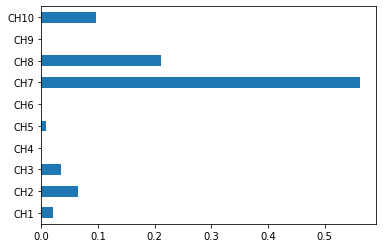

In [90]:
f_imp = tree.feature_importances_
f_imp = pd.Series(f_imp)
f_imp.index =  ['CH1','CH2','CH3','CH4','CH5','CH6','CH7','CH8','CH9','CH10']
f_imp.plot(kind='barh')
plt.show()

### - Random Forest

In [91]:
from sklearn.ensemble import RandomForestClassifier

In [92]:
n_tree=100
forest = RandomForestClassifier(n_estimators=n_tree, n_jobs=-1)
forest.fit(x_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [93]:
forest.score(x_train, y_train), forest.score(x_test, y_test)

(0.9999782229965157, 0.8766260162601626)

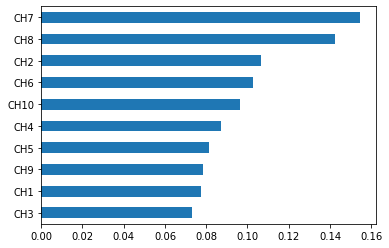

In [94]:
f_imp = forest.feature_importances_
f_imp = pd.Series(f_imp)
f_imp.index = chs
f_imp.sort_values().plot(kind='barh')
plt.show()

### - 주성분분석 (PCA)

In [95]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [96]:
scaler = StandardScaler().fit(x_train)
X_train_std = scaler.transform(x_train)
X_test_std = scaler.transform(x_test)

In [97]:
pca_2 = PCA(n_components=2).fit(X_train_std)

In [98]:
X_train_pca = pca_2.transform(X_train_std)
X_test_pca = pca_2.transform(X_test_std)

In [99]:
x_train.shape, X_train_pca.shape

((45920, 10), (45920, 2))

In [100]:
y_train.shape

(45920,)

In [101]:
m_ra=y_train==1
m_nr=y_train==0

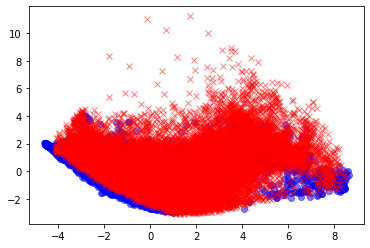

In [102]:
plt.plot(X_train_pca[m_nr,0],X_train_pca[m_nr,1], 'bo',alpha=0.5)
plt.plot(X_train_pca[m_ra,0],X_train_pca[m_ra,1], 'rx',alpha=0.5)
plt.show()

### - T-SNE

In [103]:
from sklearn.manifold import TSNE

In [104]:
X_embedded = TSNE(n_components=2).fit_transform(x_train)
X_embedded.shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(45920, 2)

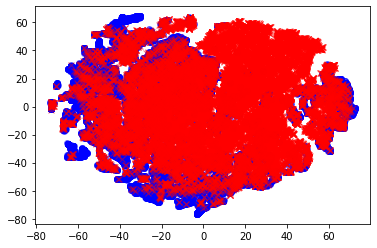

In [105]:
xs_nr =X_embedded[m_nr,0]
ys_nr =X_embedded[m_nr,1]
xs_ra =X_embedded[m_ra,0]
ys_ra =X_embedded[m_ra,1]
plt.plot(X_embedded[m_nr,0],X_embedded[m_nr,1], 'bo',alpha=0.5)
plt.plot(X_embedded[m_ra,0],X_embedded[m_ra,1], 'rx',alpha=0.5)
plt.show()